In [53]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import contractions
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We need to download all english stopwords from nltk

In [54]:
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanket/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the train dataset

In [55]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [56]:
category_map = {"fake":0,"real":1}

We will need to do some Exploratory data analysisis (EDA) such as Visualization of data.

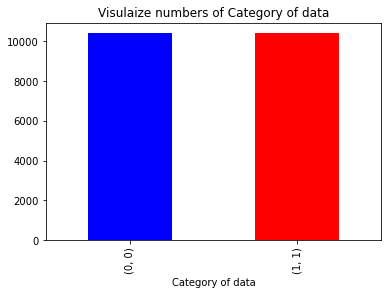

In [57]:
df_train.groupby('label').label.value_counts().plot(kind = "bar", color = ["blue", "red"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

As we can see from above plot data is balanced for both categories

We need to check if there are any null values present in data set if yes we have to handle them.

In [58]:
df_train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [59]:
df_train.dropna(subset=['text'],inplace = True)

In [60]:
df_train.isna().sum()

id           0
title      558
author    1918
text         0
label        0
dtype: int64

for NA columns such as title, author as they are string columns fill them with blank strings

In [61]:
df_train.fillna('', inplace=True)

In [62]:
df_train.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

As there are three features of each data point as "Title","Author","Text". It is better to concatenate all three columns together for better predictions.

In [63]:
df_train['articles'] = df_train['title']+' '+df_train['text']+' '+df_train['author']
df_train.head()

,id,title,author,text,label,articles
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [64]:
df_train['articles'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House In

Text in every article contains a lot of special characters. These needs to be cleaned.

In [65]:
df_train['articles'] = df_train['articles'].str.lower()
df_train['articles'] = df_train['articles'].str.replace("\\n"," ")

In [66]:
df_train['articles']

0        house dem aide: we didn’t even see comey’s let...
1        flynn: hillary clinton, big woman on campus - ...
2        why the truth might get you fired why the trut...
3        15 civilians killed in single us airstrike hav...
4        iranian woman jailed for fictional unpublished...
                               ...                        
20795    rapper t.i.: trump a ’poster child for white s...
20796    n.f.l. playoffs: schedule, matchups and odds -...
20797    macy’s is said to receive takeover approach by...
20798    nato, russia to hold parallel exercises in bal...
20799    what keeps the f-35 alive   david swanson is a...
Name: articles, Length: 20761, dtype: object

Text data needs to have proper encoding. hence we convert unicode data to ascii. especially for the quotes

In [67]:
def unicodetoascii(text):
    uni2ascii = {
            ord(bytes('\xe2\x80\x99',encoding="raw_unicode_escape").decode('utf-8')): ord("'"),
            ord(bytes('\xe2\x80\x9c',encoding="raw_unicode_escape").decode('utf-8')): ord('"'),
            ord(bytes('\xe2\x80\x9d',encoding="raw_unicode_escape").decode('utf-8')): ord('"'),
            ord(bytes('\xe2\x80\x9e',encoding="raw_unicode_escape").decode('utf-8')): ord('"'),
            ord(bytes('\xe2\x80\x9f',encoding="raw_unicode_escape").decode('utf-8')): ord('"'),
                            }
    return text.decode('utf-8').translate(uni2ascii).encode('ascii','ignore').decode("utf-8", "strict")

In [68]:
df_train['articles'] = df_train['articles'].apply(lambda x: x.encode('utf8'))

In [69]:
df_train['articles'] = df_train['articles'].apply(unicodetoascii)

In [70]:
df_train['articles']

0        house dem aide: we didn't even see comey's let...
1        flynn: hillary clinton, big woman on campus - ...
2        why the truth might get you fired why the trut...
3        15 civilians killed in single us airstrike hav...
4        iranian woman jailed for fictional unpublished...
                               ...                        
20795    rapper t.i.: trump a 'poster child for white s...
20796    n.f.l. playoffs: schedule, matchups and odds -...
20797    macy's is said to receive takeover approach by...
20798    nato, russia to hold parallel exercises in bal...
20799    what keeps the f-35 alive   david swanson is a...
Name: articles, Length: 20761, dtype: object

all the contractions such as din't, won't etc. needs to be expanded

In [72]:
import re

def decontract_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [73]:
df_train['articles'] = df_train['articles'].apply(decontract_text)

In [74]:
df_train['articles']

0        house dem aide: we did not even see comey is l...
1        flynn: hillary clinton, big woman on campus - ...
2        why the truth might get you fired why the trut...
3        15 civilians killed in single us airstrike hav...
4        iranian woman jailed for fictional unpublished...
                               ...                        
20795    rapper t.i.: trump a 'poster child for white s...
20796    n.f.l. playoffs: schedule, matchups and odds -...
20797    macy is is said to receive takeover approach b...
20798    nato, russia to hold parallel exercises in bal...
20799    what keeps the f-35 alive   david swanson is a...
Name: articles, Length: 20761, dtype: object

Lemantize text

In [77]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

In [78]:
df_train['articles'] = df_train['articles'].apply(lambda x: ' '.join(t for t in lemmatize_text(x)))

In [79]:
df_train['articles']

0        house dem aide: we did not even see comey is l...
1        flynn: hillary clinton, big woman on campus - ...
2        why the truth might get you fired why the trut...
3        15 civilian killed in single u airstrike have ...
4        iranian woman jailed for fictional unpublished...
                               ...                        
20795    rapper t.i.: trump a 'poster child for white s...
20796    n.f.l. playoffs: schedule, matchup and odds - ...
20797    macy is is said to receive takeover approach b...
20798    nato, russia to hold parallel exercise in balk...
20799    what keep the f-35 alive david swanson is an a...
Name: articles, Length: 20761, dtype: object

Remove stopwords

In [80]:
df_train['articles'] = df_train['articles'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [81]:
df_train['articles']

0        house dem aide: even see comey letter jason ch...
1        flynn: hillary clinton, big woman campus - bre...
2        truth might get fired truth might get fired oc...
3        15 civilian killed single u airstrike identifi...
4        iranian woman jailed fictional unpublished sto...
                               ...                        
20795    rapper t.i.: trump 'poster child white suprema...
20796    n.f.l. playoffs: schedule, matchup odds - new ...
20797    macy said receive takeover approach hudson bay...
20798    nato, russia hold parallel exercise balkan nat...
20799    keep f-35 alive david swanson author, activist...
Name: articles, Length: 20761, dtype: object

Remove all special characters

In [82]:
df_train['articles'] = df_train['articles'].str.replace("[^a-zA-Z0-9\s\.]+","")

In [83]:
df_train['articles']

0        house dem aide even see comey letter jason cha...
1        flynn hillary clinton big woman campus  breitb...
2        truth might get fired truth might get fired oc...
3        15 civilian killed single u airstrike identifi...
4        iranian woman jailed fictional unpublished sto...
                               ...                        
20795    rapper t.i. trump poster child white supremacy...
20796    n.f.l. playoffs schedule matchup odds  new yor...
20797    macy said receive takeover approach hudson bay...
20798    nato russia hold parallel exercise balkan nato...
20799    keep f35 alive david swanson author activist j...
Name: articles, Length: 20761, dtype: object

In [84]:
df_train.head()

,id,title,author,text,label,articles
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide even see comey letter jason cha...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,flynn hillary clinton big woman campus breitb...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired truth might get fired oc...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 civilian killed single u airstrike identifi...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,iranian woman jailed fictional unpublished sto...


Save cleaned train data to CSV

In [85]:
df_train.to_csv('clean_train.csv')

Test data needs also to be cleaned.

In [87]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [89]:
df_test.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [90]:
df_test.dropna(subset=['text'],inplace = True)

In [91]:
df_test.fillna('', inplace=True)

In [92]:
df_test.isna().sum()

id        0
title     0
author    0
text      0
dtype: int64

In [93]:
df_test['articles'] = df_test['title']+' '+df_test['text']+' '+df_test['author']
df_test.head()

,id,title,author,text,articles
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,#NoDAPL: Native American Leaders Vow to Stay A...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...","Tim Tebow Will Attempt Another Comeback, This ..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Keiser Report: Meme Wars (E995) 42 mins ago 1 ...


In [94]:
df_test['articles'] = df_test['articles'].str.lower()
df_test['articles'] = df_test['articles'].str.replace("\\n"," ")

In [95]:
df_test['articles'] = df_test['articles'].apply(lambda x: x.encode('utf8'))

In [96]:
df_test['articles'] = df_test['articles'].apply(unicodetoascii)

In [97]:
df_test['articles'] = df_test['articles'].apply(decontract_text)

In [98]:
df_test['articles'] = df_test['articles'].apply(lambda x: ' '.join(t for t in lemmatize_text(x)))

In [99]:
df_test['articles'] = df_test['articles'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [100]:
df_test['articles'] = df_test['articles'].str.replace("[^a-zA-Z0-9\s\.]+","")

In [101]:
df_test['articles']

0       specter trump loosens tongues purse strings si...
1       russian warship ready strike terrorist near al...
2       nodapl native american leader vow stay winter ...
3       tim tebow attempt another comeback time baseba...
4       keiser report meme war e995 42 min ago 1 view ...
                              ...                        
5195    bangladeshi traffic jam never end  new york ti...
5196    john kasich sign one abortion bill ohio veto r...
5197    california today what exactly sushi  new york ...
5198    300 u marine deployed russian border norway pr...
5199    awkward sex onscreen  new york time perhaps se...
Name: articles, Length: 5193, dtype: object

In [102]:
df_test.to_csv('clean_test.csv')